# Breast Cancer Predictions
### by Munachimso Aneke

In [1]:
# Import needed Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from matplotlib.colors import ListedColormap

from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, precision_score, f1_score, recall_score, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC


## Introduction
### Project Goal
The goal of this project is to predict if a breast mass is malignant or benign based on charateristics of its cell nuclei. The prediction will be done using two different machine learning techniques. One model will be created using Random Forest Classifier and the other will be done using Support Vector Machine. In both models, recall would be prioritized because we want to make sure the model catches all malignant cases.

Being able to predict breast cancer saves people from undergoing more invasive and painful procedures and allows early detection.

The dataset contains 569 instance, 30 predictive feature, and 1 target feature. The predictive features are the mean, standard error, and worst (or mean of the three largest values) of the following characteristics:
1. radius (mean of distances from center to points on the perimeter)
2. texture (standard deviation of gray-scale values)
3. perimeter
4. area
5. smoothness (local variation in radius lengths)
6. compactness (perimeter^2 / area - 1.0)
7. concavity (severity of concave portions of the contour)
8. concave points (number of concave portions of the contour)
9. symmetry
10. fractal dimension ("coastline approximation" - 1)

Data Source: https://archive.ics.uci.edu/dataset/17/breast+cancer+wisconsin+diagnostic
### Fetch and Clean Data

In [2]:
# Install the ucimlrepo
pip install ucimlrepo # uncomment to install package, comment after installation

The ID column is dropped since it is not needed for this analysis. This dataset contains no missing values. I have also changed the column headings so we can easily identify between mean, standard error, and 'worst' features.

In [3]:
# Download DataSet
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
df = breast_cancer_wisconsin_diagnostic.data.original

df.dropna() # just incase there's a missing value

# Drop ID column
df = df.drop('ID', axis=1)

# Dictionary of new column names
new_col_names = {
    'radius1':'radius_mean', 'texture1':'texture_mean', 'perimeter1':'perimeter_mean', 'area1':'area_mean', 
    'smoothness1':'smoothness_mean', 'compactness1':'compactness_mean', 'concavity1':'concavity_mean', 
    'concave_points1':'concave_points_mean', 'symmetry1':'symmetry_mean', 'fractal_dimension1':'fractal_dimension_mean', 
    'radius2':'radius_se', 'texture2':'texture_se', 'perimeter2':'perimeter_se', 'area2':'area_se', 
    'smoothness2':'smoothness_se', 'compactness2':'compactness_se', 'concavity2':'concavity_se', 
    'concave_points2':'concave_points_se', 'symmetry2':'symmetry_se', 'fractal_dimension2':'fractal_dimension_se', 
    'radius3':'radius_worst', 'texture3':'texture_worst', 'perimeter3':'perimeter_worst', 'area3':'area_worst', 
    'smoothness3':'smoothness_worst', 'compactness3':'compactness_worst', 'concavity3':'concavity_worst', 
    'concave_points3':'concave_points_worst', 'symmetry3':'symmetry_worst', 'fractal_dimension3':'fractal_dimension_worst', 
}
df.rename(columns=new_col_names, inplace = True)
df.head()



,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,M
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,M


For easy analysis, a diagnosis marked as 0 is Benign (B) and a diagnosis marked as 1 is malignant (M).

In [4]:
# Convert categorical values to numerical values
# B = 0, M = 1

label_encoder = LabelEncoder()
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])
df.head()


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,1
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,1
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,1
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,1
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,1


## Exploratory Data Analysis
### Quick Data Summary
A quick summary of the continuous variables in the dataset. The mean and median (50%) gives us an idea of the distribution of the data. We can also get an idea about the ranges of the features by looking at the maximum and minimum data points.

In [5]:
summary = df.describe()
summary.drop('Diagnosis', axis=1)
summary

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,Diagnosis
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,...,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.372583
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,...,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,...,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,...,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,0.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,...,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


### Target Univariate Analysis
Approximately 63% of the instances is benign and the remaining 37% of the instances is malignant. This means our dataset is unbalanced. Using the bar chart we can the number of benign (0) and malignant (1) instances.

Percentages:

	Benign (0): 62.74 
	Malignant (1) 37.26


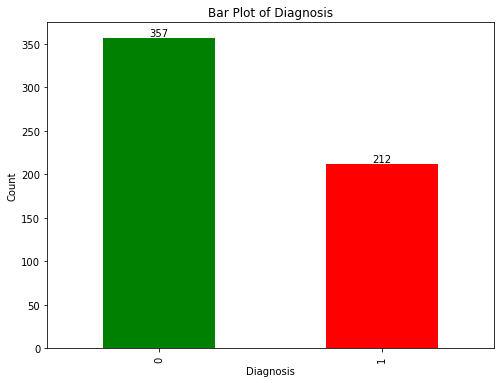

In [6]:
# Percentage for each class
percentages = df['Diagnosis'].value_counts(normalize=True) * 100
print("Percentages:\n")
print("\tBenign (0):", round(percentages[0], 2), "\n\tMalignant (1)", round(percentages[1], 2))

# Bar plot
count = df['Diagnosis'].value_counts()

plt.figure(figsize=(8, 6))
bar_plt = df['Diagnosis'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Bar Plot of Diagnosis')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

for i, v in enumerate(count):
    bar_plt.text(i, v + 0.1, str(v), color='black', ha='center', va='bottom')


plt.show()

### Features Relationships

#### HeatMap
Let's see how the predictive variables are correlated which other using a heatmap


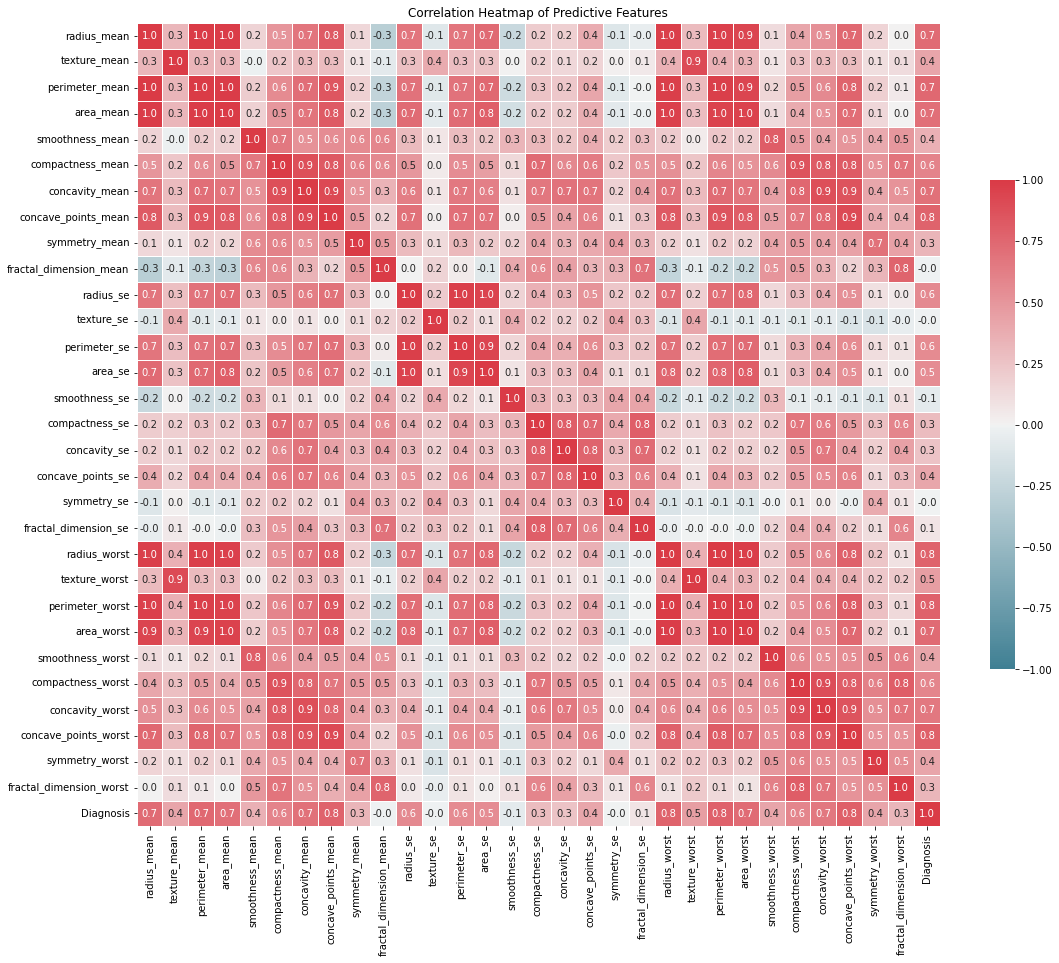

In [7]:
corr_matrix = df.corr()

f, ax = plt.subplots(figsize=(18, 18))

# Custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
heatmap = sns.heatmap(corr_matrix, annot= True, cmap=cmap, fmt= '.1f', vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
heatmap.set_title('Correlation Heatmap of Predictive Features')
# Show plot
plt.show()

From the Heatmap above, we can see that some features correlate with each other. If I was using the heatmap to select features to train the model (which we would not do), I could take `radius_mean` and drop `perimeter_mean` and `area_mean`.

#### Scatter Plots
Now let's take a look at some scatter plots modeling the correlation between some of the features.

1. High positive correlation between `radius_mean` and `perimeter_mean`: <br>
    We can also see that majority of malignant mass have a higher perimeter and radius mean

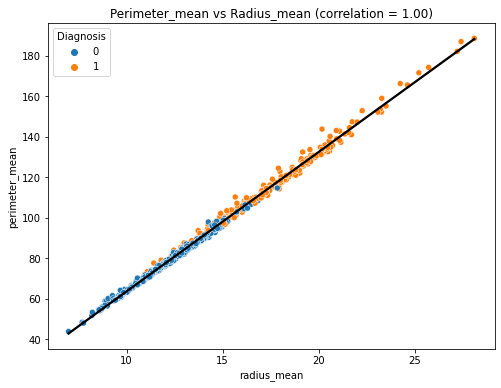

In [8]:
x = df['radius_mean']
y = df['perimeter_mean']

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, hue=df['Diagnosis'])

# Fitting and plotting the line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Adding title and labels
corr_coef = np.corrcoef(x, y)[0, 1]
plt.title(f'Perimeter_mean vs Radius_mean (correlation = {corr_coef:.2f})')
plt.xlabel('radius_mean')
plt.ylabel('perimeter_mean')

# Displaying the plot
plt.show()

2. No correlation between `texture_mean` and `Symmetry_Se`:<br>
   Although there is no correlation between these features. Looking at the graph below we can see that majority of benign cases has a lower texture mean.

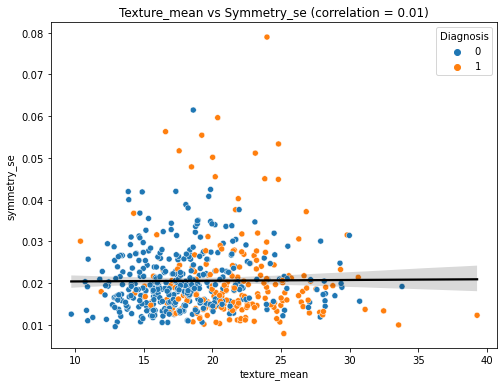

In [9]:
x = df['texture_mean']
y = df['symmetry_se']

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, hue=df['Diagnosis'])

# Fitting and plotting the line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Adding title and labels
corr_coef = np.corrcoef(x, y)[0, 1]
plt.title(f'Texture_mean vs Symmetry_se (correlation = {corr_coef:.2f})')
plt.xlabel('texture_mean')
plt.ylabel('symmetry_se')

# Displaying the plot
plt.show()

3. Weak negative correlation between `fractal_dimension_mean` and `area_mean`: <br>
We can also see that majority of malignant mass have a higher area mean. We cannot really make such predictions using fractal dimension mean.

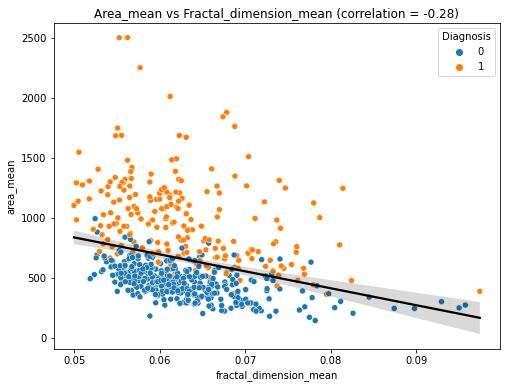

In [10]:
x = df['fractal_dimension_mean']
y = df['area_mean']

plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, hue=df['Diagnosis'])

# Fitting and plotting the line of best fit
sns.regplot(x=x, y=y, scatter=False, color='black')

# Adding title and labels
corr_coef = np.corrcoef(x, y)[0, 1]
plt.title(f'Area_mean vs Fractal_dimension_mean (correlation = {corr_coef:.2f})')
plt.xlabel('fractal_dimension_mean')
plt.ylabel('area_mean')

# Displaying the plot
plt.show()

#### Distribution
Lastly, lets take a look at the distribution for the predictive variables to see if we might need to transform them.

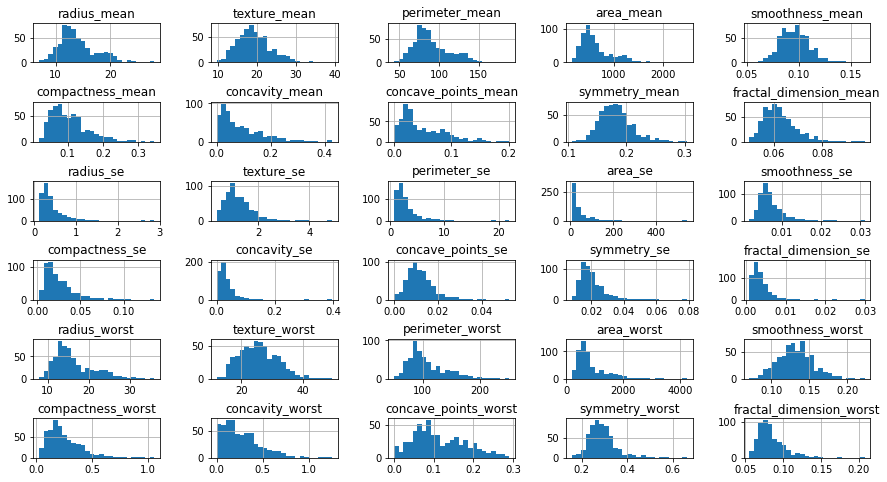

In [11]:
df.iloc[:, :-1].hist(figsize=(15, 8), bins=25, layout=(6, 5)) # Plot all columns except the last one
plt.subplots_adjust(wspace=0.4, hspace=1)

plt.show()

Although some of the features have a skewed or non-normal distribution, the shape of the distribution is not as important in this analysis. This is because the machine learning algorithms I am implementing are not sensitive to the distribution type.

## Modeling

### Split into Train and Test 
From above, we can know that 62.74% of the dataset instances is Benign (0) and 37.26% of the dataset instances Malignant (1) 37.26. Since the dataset is unbalanced, I will be using a stratified `test_train_split` method based on Diagnosis with test size being 30%. A `random_state` is set to `42` for reproducibility.  

In [12]:
seed = 42 

X = df.iloc[:, :-1]
y = df['Diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=seed, stratify = y)


#print(X_train, X_test, y_train, y_test)

### Feature Selection
The dataset contains thirty predictive features. We need to the determine the optimal number of features and which features are important. I will be using the recursive feature elimination with cross validation to determine this. My scoring metric is `recall` because the cost of false negatives is high when predicting cancer. A `random_state` is set to `42` for reproducibility.

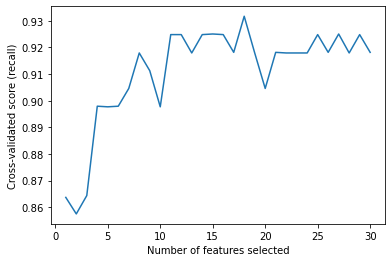

Optimal number of features: 18


In [13]:
#warnings.filterwarnings('ignore')
# Create a base model
rf_estimator = RandomForestClassifier(random_state = seed)

# RFE with cross-validation

cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state=seed)

custom_scorer = 'recall'

rfecv = RFECV(estimator=rf_estimator, step=1, cv=cv, scoring=custom_scorer)
rfecv.fit(X_train, y_train)

# Plot number of features vs. cross-validated scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validated score (recall)")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.show()

# Determine the optimal number of features
optimal_num_features = rfecv.n_features_
print("Optimal number of features: {}".format(optimal_num_features))



For this project the optimal number of features chosen is 18 (random_state = 42). The barchart below shows the which features were selected.

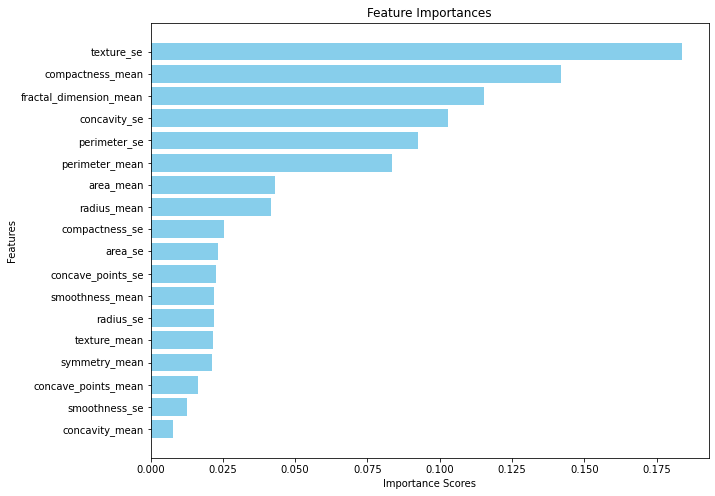

In [14]:
# Get the ranking of features, and feature importance, 
selected_feature_mask = rfecv.support_
feature_ranking = rfecv.ranking_
feature_importances =  rfecv.estimator_.feature_importances_

# Combine feature names, rankings, and importances
feature_info = [(feature, rank, importance) for feature, rank, importance in zip(X.columns, feature_ranking, feature_importances)]

# Sort the features by importance
feature_info.sort(key=lambda x: x[2])

# Extract sorted feature names and importances
sorted_features = [info[0] for info in feature_info]
sorted_importances = [info[2] for info in feature_info]

# Create a horizontal bar plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance Scores')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()



### Scaling
Now we have selected the important features, we want to scale the dataset. The features have different scales, and we want the features to contribute equally to the model fitting. 

In [15]:
X_train_selected = X_train.iloc[:, rfecv.support_]
X_test_selected = X_test.iloc[:, rfecv.support_]

scaler = StandardScaler()

# for random forest model
X_train_scaled_rf = scaler.fit_transform(X_train_selected)
X_test_scaled_rf = scaler.transform(X_test_selected)

# Make a copy for support vector machine model incase changes are made to rf
X_train_scaled_svm = X_train_scaled_rf.copy()
X_test_scaled_svm = X_test_scaled_rf.copy()

We have split the dataset into a training and testing sets (70/30), selected our features, and scaled the data using `StandardScaler()`. We can now create and evaluate our models.

### Random Forest Classifier Model

#### Hyperparameter Tuning
 Before we fit the model, we need to tune our hyperparameters for our the Random Forest Classifier. `Random_state` is set to `42` for reproducibility. 

In [16]:
# Define the parameters for grid search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Create a base model
rf = RandomForestClassifier(random_state = seed)

# Create a grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=custom_scorer)
grid_search.fit(X_train_scaled_rf, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 100}


Using GridSearchCV (more exhaustive procedure), we have decided that the model's hyper paramters.

#### Train Model and Predict
Now we create the model. I will also be using a `random_state` of `42` for reproducibility.

In [17]:
rf = RandomForestClassifier(n_estimators=100, criterion='gini', max_features= 'auto', min_samples_leaf = 1, random_state=42)
rf.fit(X_train_scaled_rf, y_train)

y_pred_rf = rf.predict(X_test_scaled_rf)


#### Evaluate Model
To evaluate the model, I will be looking at the classification report, confusion matrix, and the precision-recall curves.


Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       107
           1       1.00      0.92      0.96        64

    accuracy                           0.97       171
   macro avg       0.98      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



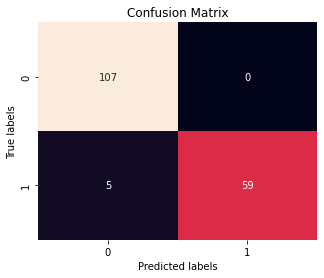

In [18]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)

#TN = cm_rf[0, 0]
#FP = cm_rf[0, 1]  
#FN = cm_rf[1, 0] 
#TP = cm_rf[1, 1]

plt.figure(figsize=(5, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Our random forest classifier model is approximately `97%` accurate. But since our dataset is unbalanced, we look at the precision and recall score from the classification report for more information. <br>
The model correctly predicted `96%` of the test data correctly for benign cases, and `100%` for malignant cases. For recall, the model captured `100%` of all actual positive cases for benign cases and `92%` for malignant cases.

From the confusion matrix we can see that the values of false negatives, and false positives are relatively low.

To summarize the model performance on both the training and testing dataset I will be using the precision-recall curve.

(0.0, 1.05)

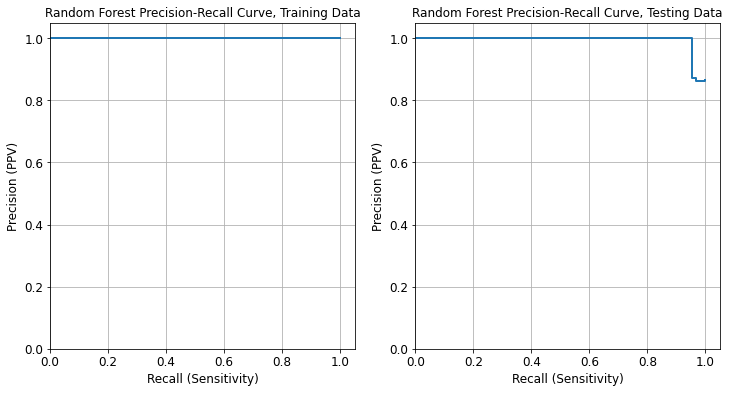

In [19]:
fig_rf, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
fs = 12

# plot curve for training set
y_train_prob_rf = rf.predict_proba(X_train_scaled_rf)[:, 1]
y_test_prob_rf = rf.predict_proba(X_test_scaled_rf)[:, 1]

precision_train_rf, recall_train_rf, thresholds_train_rf = precision_recall_curve(y_train, y_train_prob_rf)

ax1.step(recall_train_rf, precision_train_rf, linewidth=2)
ax1. grid()

ax1.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax1.set_ylabel('Precision (PPV)', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('Random Forest Precision-Recall Curve, Training Data')
ax1.set_ylim([0, 1.05])
ax1.set_xlim([0, 1.05])

# plot curve for Testing set

precision_test_rf, recall_test_rf, thresholds_test_rf = precision_recall_curve(y_test, y_test_prob_rf)

ax2.step(recall_test_rf, precision_test_rf, linewidth=2)
ax2. grid()

ax2.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax2.set_ylabel('Precision (PPV)', fontsize=fs)
ax2.tick_params(axis='both', labelsize=fs)

ax2.set_title('Random Forest Precision-Recall Curve, Testing Data')
ax2.set_ylim([0, 1.05])
ax2.set_xlim([0, 1.05])



The precision-recall curve on the training data shows that the model has achieved perfect precision and recall at any threshold, which somewhat applies to the testing data. 
Just to make sure that there is no overfitting we can look at the training and testing accuracy set scores below. Since both values are quite close, we can say this model looks great.

Compared to the no information rate, which would have an accuracy of approx. `63%` this model is an improvement

In [20]:
rf_train_score = rf.score(X_train_scaled_rf, y_train)
rf_test_score = rf.score(X_test_scaled_rf, y_test)

print(f'Training Set Score {rf_train_score:.2f}')
print(f'Testing Set Score {rf_test_score:.2f}')

Training Set Score 1.00
Testing Set Score 0.97


### Support Vector Machine

For fair comparison to the random forest model we would be using the same features selected by the recursive feature elimination performed earlier for this model. 

#### Hyperparameter Tuning
Like before, we need to tune our hyperparameters. Recall will still be the priority, and random_state (42) is used for reproducibility.

In [21]:
param_grid_svm = {'C': [0.1, 1, 10, 100],
                  'gamma': [1, 0.1, 0.01, 0.001, 'scale'],
                  'kernel': ['rbf', 'linear', 'poly']
             }


# Create base model
svm = SVC(class_weight = 'balanced', random_state = seed)

grid_search_svm = GridSearchCV(estimator=svm, param_grid=param_grid_svm, scoring = custom_scorer, refit = True)
grid_search_svm.fit(X_train_scaled_svm, y_train)

# Get the best parameters
best_params_svm = grid_search_svm.best_params_
print("Best Parameters:", best_params_svm)


Best Parameters: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


#### Train Model and Predict

In [22]:
svm = SVC(C= 1, gamma = 1, kernel = 'rbf', class_weight = 'balanced', random_state = 42, probability = True)

svm.fit(X_train_scaled_svm, y_train)

y_pred_svm = svm.predict(X_test_scaled_svm)

#### Evaluate Model
Similar to the evaluation of the random forest classifier model, I will be looking at the classification report, confusion matrix, and the precision-recall curves.

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       107
           1       0.90      0.98      0.94        64

    accuracy                           0.95       171
   macro avg       0.95      0.96      0.95       171
weighted avg       0.96      0.95      0.95       171



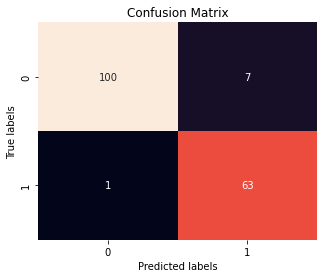

In [23]:
print("Classification Report:")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()



Our support vector classifier model is approximately `95%` accurate. 

The model correctly predicted `99%` of the test data correctly for benign cases, and `90%` for malignant cases. For recall, the model captured `93%` of all actual positive cases for benign cases and `98%` for malignant cases.

From the confusion matrix we can see that the values of false negatives, and false positives are relatively low.

To summarize the model performance on both the training and testing dataset I will be using the precision-recall curve.

(0.0, 1.05)

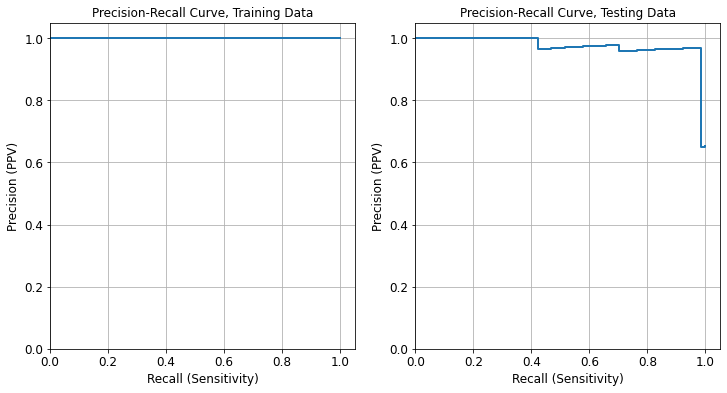

In [24]:
fig_svm, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
fs = 12

# plot curve for training set
y_train_prob_svm = svm.predict_proba(X_train_scaled_svm)[:, 1]
y_test_prob_svm = svm.predict_proba(X_test_scaled_svm)[:, 1]

precision_train_svm, recall_train_svm, thresholds_train_svm = precision_recall_curve(y_train, y_train_prob_svm)

ax1.step(recall_train_svm, precision_train_svm, linewidth=2)
ax1. grid()

ax1.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax1.set_ylabel('Precision (PPV)', fontsize=fs)
ax1.tick_params(axis='both', labelsize=fs)

ax1.set_title('Precision-Recall Curve, Training Data')
ax1.set_ylim([0, 1.05])
ax1.set_xlim([0, 1.05])

# plot curve for Testing set

precision_test_svm, recall_test_svm, thresholds_test_svm = precision_recall_curve(y_test, y_test_prob_svm)

ax2.step(recall_test_svm, precision_test_svm, linewidth=2)
ax2. grid()

ax2.set_xlabel('Recall (Sensitivity)', fontsize=fs)
ax2.set_ylabel('Precision (PPV)', fontsize=fs)
ax2.tick_params(axis='both', labelsize=fs)

ax2.set_title('Precision-Recall Curve, Testing Data')
ax2.set_ylim([0, 1.05])
ax2.set_xlim([0, 1.05])


The precision-recall curve on the training data shows that the model has achieved perfect precision and recall at any threshold, which does not apply as much to the testing data like the random classifier model. 

Just to make sure that there is no overfitting we can look at the training and testing accuracy set scores below. Both values are quite close, so we can still say this model looks great.

Compared to the no information rate, which would have an accuracy of approx. 63% this model is also an improvement

In [25]:
svm_train_score = svm.score(X_train_scaled_svm, y_train)
svm_test_score = svm.score(X_test_scaled_svm, y_test)

print(f'Training Set Score {svm_train_score:.2f}')
print(f'Testing Set Score {svm_test_score:.2f}')


Training Set Score 1.00
Testing Set Score 0.95


## Summary

The goal of the project was to predict malignant and benign breast mass, with a recall priority to ensure that all malignant cases are caught. While the random forest classifier has a higher accuracy and precision score, the goal of this analysis is maximize the recall for malignant cases making the support vector machine model the better in line with the goal.

Both models are a significant improvement from the prediction based on the no information rate.




For video presentation:
https://asu.zoom.us/rec/share/TszsZpGttM1zmjmW-_jTMLVTgtOrRC1qtePNiES_o2nKHSeaZd3nlyCzan5ncUcy.2P4bZt5cQJ7pj8By